In [1]:
import torch
import warnings
from torch.nn import functional as F

from devinterp.optim import SGLD
from devinterp.slt.sampler import estimate_learning_coeff_with_summary
from devinterp.utils import plot_trace, default_nbeta

from load_trained_model import load_trained_model
from torchinfo import summary

warnings.filterwarnings("ignore")

In [2]:
import numpy as np

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def evaluate(model, data):
    """Evaluate function for trained model.
    
    The trained model outputs logits of shape [batch_size, seq_len, vocab_size].
    We need to flatten them for cross-entropy loss computation.
    """
    # Unpack the batch - data is a list of (input, target) tuples
    inputs, targets = data[0]
    
    # Add batch dimension if needed
    if inputs.dim() == 1:
        inputs = inputs.unsqueeze(0)
    if targets.dim() == 1:
        targets = targets.unsqueeze(0)
    
    # Move to device
    inputs = inputs.to(DEVICE)
    targets = targets.to(DEVICE)

    # Get model output
    model_output = model(inputs)  # [batch_size, seq_len, vocab_size]

    # Compute cross-entropy loss
    # model_output: [batch_size, seq_len, vocab_size]
    # targets: [batch_size, seq_len]
    loss = F.cross_entropy(
        model_output.reshape(-1, model_output.size(-1)),  # [batch_size * seq_len, vocab_size]
        targets.reshape(-1)  # [batch_size * seq_len]
    )
    
    if torch.isnan(loss) or torch.isinf(loss):
        print("NaN or Inf detected:")
        print("Inputs:", inputs)
        print("Model output:", model_output)
        print("Targets:", targets)
        print("Loss:", loss)
    
    return loss, {
        "logits": model_output
    }

In [3]:
# Create a custom data loader for the trained model
import random
from itertools import product
from torch.utils.data import Dataset, DataLoader

class TrainedModelDataset(Dataset):
    """Dataset for trained reverse model."""
    def __init__(self, vocab, vocab_to_idx, num_samples=1000, max_seq_len=7):
        self.data = []
        self.max_seq_len = max_seq_len
        
        # Generate sequences
        for length in range(1, 5):
            for seq_tuple in product(list(vocab), repeat=length):
                if len(self.data) >= num_samples:
                    break
                seq = list(seq_tuple)
                input_seq = ["BOS"] + seq
                target_seq = ["BOS"] + seq[::-1]
                
                # Convert to indices
                input_ids = [vocab_to_idx[token] for token in input_seq]
                target_ids = [vocab_to_idx[token] for token in target_seq]
                
                # Pad sequences
                input_padded = input_ids + [0] * (max_seq_len - len(input_ids))
                target_padded = target_ids + [0] * (max_seq_len - len(target_ids))
                
                self.data.append((input_padded, target_padded))
        
        # Fill with random sequences if needed
        while len(self.data) < num_samples:
            length = random.randint(1, 4)
            seq = [random.choice(list(vocab)) for _ in range(length)]
            input_seq = ["BOS"] + seq
            target_seq = ["BOS"] + seq[::-1]
            
            input_ids = [vocab_to_idx[token] for token in input_seq]
            target_ids = [vocab_to_idx[token] for token in target_seq]
            
            input_padded = input_ids + [0] * (max_seq_len - len(input_ids))
            target_padded = target_ids + [0] * (max_seq_len - len(target_ids))
            
            self.data.append((input_padded, target_padded))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        input_tensor = torch.tensor(self.data[idx][0], dtype=torch.long)
        target_tensor = torch.tensor(self.data[idx][1], dtype=torch.long)
        return (input_tensor, target_tensor)

def identity_collate(batch):
    """Simple collate function that returns batch as-is for compatibility."""
    return batch

In [11]:
# Load the trained model
model, metadata = load_trained_model("trained_reverse_model.pth")
model = model.to(DEVICE)
model.eval()  # Set to evaluation mode

# print(f"Loaded model with {sum(p.numel() for p in model.parameters()):,} parameters")
# print(f"Vocabulary: {metadata['vocab']}")
# print(f"Model architecture: {metadata['model_params']}")

SimpleTrainedTransformer(
  (token_embedding): Embedding(6, 75)
  (position_embedding): Embedding(10, 75)
  (layers): ModuleList(
    (0-3): 4 x ModuleDict(
      (attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=75, out_features=75, bias=True)
      )
      (norm1): LayerNorm((75,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=75, out_features=110, bias=True)
        (1): ReLU()
        (2): Linear(in_features=110, out_features=75, bias=True)
      )
      (norm2): LayerNorm((75,), eps=1e-05, elementwise_affine=True)
    )
  )
  (output_proj): Linear(in_features=75, out_features=6, bias=True)
)

In [12]:
# Create the data loader using metadata from loaded model
dataset = TrainedModelDataset(
    vocab=metadata['vocab'], 
    vocab_to_idx=metadata['vocab_to_idx'],
    num_samples=1000,
    max_seq_len=7
)
loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=identity_collate)
print(f"Created dataloader with {len(dataset)} samples")

Created dataloader with 1000 samples


In [13]:
# Estimate learning coefficient
learning_coeff_stats = estimate_learning_coeff_with_summary(
    model,
    loader=loader,
    evaluate=evaluate,
    sampling_method=SGLD,
    optimizer_kwargs=dict(lr=1e-5, localization=100.0, nbeta=default_nbeta(loader)),
    num_chains=10,  # How many independent chains to run
    num_draws=100,  # How many samples to draw per chain
    num_burnin_steps=0,  # How many samples to discard at the beginning of each chain
    num_steps_bw_draws=1,  # How many steps to take between each sample
    device=DEVICE,
    online=True,
)

Chain 0:   0%|          | 0/100 [00:00<?, ?it/s]

Chain 9: 100%|██████████| 100/100 [00:00<00:00, 237.41it/s]


In [14]:
# Extract loss trace
trace = learning_coeff_stats["loss/trace"]

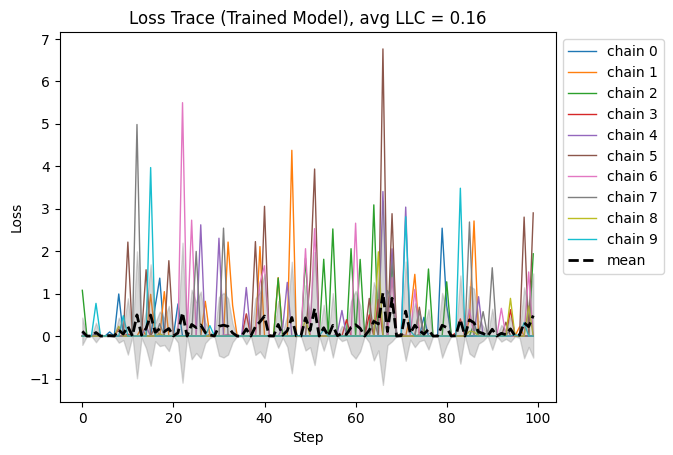

<Figure size 1200x900 with 0 Axes>

In [15]:
# Plot the results
plot_trace(
    trace,
    "Loss",
    x_axis="Step",
    title=f"Loss Trace (Trained Model), avg LLC = {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

In [10]:
# Display LLC statistics
print("\nLearning Coefficient Statistics:")
print(f"Mean LLC: {sum(learning_coeff_stats['llc/means']) / len(learning_coeff_stats['llc/means']):.4f}")
print(f"LLC per chain: {learning_coeff_stats['llc/means']}")


Learning Coefficient Statistics:
Mean LLC: -0.1036
LLC per chain: [-0.19055626 -0.24370697 -0.25118035 -0.25133172 -0.23686182 -0.09885367
 -0.25133908 -0.25040835 -0.17233598 -0.21289659  0.8637794  -0.09225003
 -0.20591196  0.22366159 -0.25134537  0.01319259 -0.2364486  -0.23254187
 -0.24603367 -0.07906003 -0.19732678 -0.16925386 -0.24614127 -0.25133803
 -0.25134537 -0.25097424 -0.25131384 -0.19636762  0.16053382 -0.23539272
  0.04264068 -0.19698316  0.38823146 -0.07524219 -0.11643986  0.13137664
 -0.14643869 -0.1735661  -0.2056156  -0.24105135  0.62688094 -0.24941282
 -0.12845954  0.0761269  -0.23767197 -0.2513454  -0.18346635 -0.25122413
 -0.04688756 -0.2513444  -0.14035946 -0.25119096 -0.23934177 -0.22002432
 -0.24619865 -0.08652872  0.0231117   0.207656    0.06545971 -0.25133157
 -0.08411136  0.5620901   0.18432872  0.07296573 -0.2430958  -0.24864855
 -0.23890671  0.04929418 -0.00186853 -0.24482389 -0.25134537  0.49237242
  0.4400298  -0.2512793  -0.10051829  0.25035167 -0.25134